In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pybedtools as pb
import numpy as np
from scipy import stats
import pybedtools as pb
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : '12'}

plt.rc('font', **font)

# DE genes related to tissue specific 5fC-nucleosomes


Compute the distribution of logFC from RNA-seq derived differential expression (DE) for genes associated with tissue specific enhancers, and a subset of those that have enhancers overlapping with tissue-unique 5fC-containing nucleosomes.

The list of enhancer location and their associtate genes was taken from Suppl. Table 7 in  doi:10.1038/nature11243, also available from Mouse Encode Project at Ren Lab (http://chromosome.sdsc.edu/mouse/download.html).  
Each enhancer site was considered to span +/-1.5 Kb around the center of the predicted enhancer. These files have been named `mm9_enhancer_brain_slop_1500.bed` and `mm9_enhancer_heart_slop_1500.bed`.

This notebook requires the following datasets, 

- `expr_diff.brain_vs_heart_wt.edgeR.txt` and `expr_diff.brain_vs_heart_wt.edgeR.txt`, which can be obtained following 
the protocol described [here](https://github.com/sblab-bioinformatics/5fC-nucleosome/blob/master/RNA-seq/README.md).
- `5fC_unique_to_brain_WT.bed.gz`, `5fC_unique_to_brain_KO.bed.gz`, `5fC_unique_to_heart_WT.bed.gz`, `5fC_unique_to_brain_WT.bed.gz`, `5fC_unique_to_heart_KO.bed.gz`, which can be obtained following the protocols described [here](https://github.com/sblab-bioinformatics/5fC-nucleosome/blob/master/5fC_sites_in_heart_brain_WT_and_TDG_KO/README.md).
- `ConsensusNucleosome_iNPS_Brain_WT_noMT.bed`, `ConsensusNucleosome_iNPS_Heart_WT_noMT.bed`, `ConsensusNucleosome_iNPS_Brain_KO_noMT.bed`, `ConsensusNucleosome_iNPS_Heart_KO_noMT.bed`, which can be obtained following the protocols described [here](https://github.com/sblab-bioinformatics/5fC-nucleosome/blob/master/MNase-seq/README.md).

---

Initial preparations, such as creating a dictionary of DE genes and their associated logFC, and some handy 
functions for later usage.


### Prepare a dictionary of genes with their logFC from our DE analysis

We create one with FDR<0.05 filtered genes and one containing all of them

First for the WT

In [2]:
expr = {}

with open("expr_diff.brain_vs_heart_wt.edgeR.txt", "r") as fo:
        for l in fo.read().splitlines():
            if l.split("\t")[0] != "gene_id":
                gene_name = l.split("\t")[1]
                fdr = float(l.split("\t")[-2])
                logF = float(l.split("\t")[2])
                if "," in gene_name:
                    for test in gene_name.split(","): 
                        if fdr < 0.05:
                            expr.setdefault(test.upper(),logF) 
                else:
                    if fdr < 0.05:
                        expr.setdefault(gene_name.upper(),logF)

expr_all = {}
with open("expr_diff.brain_vs_heart_wt.edgeR.txt", "r") as fo:
        for l in fo.read().splitlines():
            if l.split("\t")[0] != "gene_id":
                gene_name = l.split("\t")[1]
                fdr = float(l.split("\t")[-2])
                logF = float(l.split("\t")[2])
                if "," in gene_name:
                    for test in gene_name.split(","): 
                        expr_all.setdefault(test.upper(),logF) 
                else:
                    expr_all.setdefault(gene_name.upper(),logF)

And now for the TDG-KO

In [3]:
expr_ko = {}

with open("expr_diff.brain_vs_heart_ko.edgeR.txt", "r") as fo:
        for l in fo.read().splitlines():
            if l.split("\t")[0] != "gene_id":
                gene_name = l.split("\t")[1]
                fdr = float(l.split("\t")[-2])
                logF = float(l.split("\t")[2])
                if "," in gene_name:
                    for test in gene_name.split(","): 
                        if fdr < 0.05:
                            expr_ko.setdefault(test.upper(),logF) 
                else:
                    if fdr < 0.05:
                        expr_ko.setdefault(gene_name.upper(),logF)

expr_all_ko = {}
with open("expr_diff.brain_vs_heart_ko.edgeR.txt", "r") as fo:
        for l in fo.read().splitlines():
            if l.split("\t")[0] != "gene_id":
                gene_name = l.split("\t")[1]
                fdr = float(l.split("\t")[-2])
                logF = float(l.split("\t")[2])
                if "," in gene_name:
                    for test in gene_name.split(","): 
                        expr_all_ko.setdefault(test.upper(),logF) 
                else:
                    expr_all_ko.setdefault(gene_name.upper(),logF)

In [4]:
# Handy functions to generate a list of genes associated with a given 
# bed file (bed_file) that are in a dictionary (expr)
def find_genes_DE_inbed(bed_file, expr):
    for b in bed_file:
        if b.name.upper() in expr:
            yield b.name
# Return the logFC of genes associated with a given genomic interval
# from a dict 
def find_DE_inbed(bed_file, expr):
    for b in bed_file:
        if b.name.upper() in expr:
            yield expr[b.name.upper()]

### Number of DE genes for which we have enhancer annotation Brain/Heart

In [5]:
## These one-column text file simply contain unique gene names found in the Ren Lab list of brain/heart enhancers
genes_enhancer_brain = np.genfromtxt("genes_in_enhancer_brain.txt", dtype="str")
genes_enhancer_heart = np.genfromtxt("genes_in_enhancer_heart.txt", dtype="str")

Create a list containing the logFC for all genes present in the Ren Lab list of 
enhancers, both for brain and heart 

In [6]:
de_enhancer_brain = set()
for g in genes_enhancer_brain:
    if g.upper() in expr:
        de_enhancer_brain.add(expr[g.upper()])
de_enhancer_heart = set()
for g in genes_enhancer_heart:
    if g.upper() in expr:
        de_enhancer_heart.add(expr[g.upper()])

# no matter the fdr 
        
all_enhancer_brain = set()
for g in genes_enhancer_brain:
    if g.upper() in expr_all:
        all_enhancer_brain.add(expr_all[g.upper()])
all_enhancer_heart = set()
for g in genes_enhancer_heart:
    if g.upper() in expr_all:
        all_enhancer_heart.add(expr_all[g.upper()])

Now let's find the logFC of genes associated with enhancers which have tissue-unique 5fC-associtated nucleosomes

## Start with TDG WT 

### Find 5fC-associated nucleosomes 

In [7]:
u5fC_brain = pb.BedTool("5fC_unique_to_brain_WT.bed.gz")
u5fC_heart = pb.BedTool("5fC_unique_to_heart_WT.bed.gz")
nuc_cons_brain = pb.BedTool("ConsensusNucleosome_iNPS_Brain_WT_noMT.bed")
nuc_cons_heart = pb.BedTool("ConsensusNucleosome_iNPS_Heart_WT_noMT.bed")

In [8]:
# we set the overlap to 80% of the nucleosome region
overlap=0.8
u5fC_brain_nuc = u5fC_brain.intersect(nuc_cons_brain, F=overlap, r=False)
u5fC_heart_nuc = u5fC_heart.intersect(nuc_cons_heart, F=overlap, r=False)

In [9]:
print("Number of 5fC-nuc_cons Brain:", len(u5fC_brain_nuc))
print("Number of 5fC-nuc_cons Heart:", len(u5fC_heart_nuc))

Number of 5fC-nuc_cons Brain: 1898
Number of 5fC-nuc_cons Heart: 393


### Intersect enhancers with 5fC-nucleosome

In [10]:
# Enhancers from Ren Lab mm9 brain and heart
enhancer_brain = pb.BedTool("mm9_enhancer_brain_slop_1500.bed")
enhancer_heart = pb.BedTool("mm9_enhancer_heart_slop_1500.bed")
# BRAIN
num_b_5fCNuc_de = []
enhancers_unique_brain = enhancer_brain.intersect(u5fC_brain_nuc)
print("Brain WT DE 5fC-Nuc from Ren Lab enhancers --", len(set(find_genes_DE_inbed(enhancers_unique_brain, expr))))
num_b_5fCNuc_de.append(len(set(find_genes_DE_inbed(enhancers_unique_brain, expr))))
logfc_b_5fCNuc_de = set(find_DE_inbed(enhancers_unique_brain, expr))

enhancers_not_unique_brain = enhancer_brain.intersect(u5fC_brain_nuc, v=True)
logfc_b_not_5fCNuc_de = set(find_DE_inbed(enhancers_not_unique_brain, expr))

# HEART
num_h_5fCNuc_de = []
enhancers_unique_heart = enhancer_heart.intersect(u5fC_heart_nuc)
print("Heart WT DE 5fC-Nuc from Ren Lab enhancers --", len(set(find_genes_DE_inbed(enhancers_unique_heart, expr))))
num_h_5fCNuc_de.append(len(set(find_genes_DE_inbed(enhancers_unique_heart, expr))))
logfc_h_5fCNuc_de = set(find_DE_inbed(enhancers_unique_heart, expr))

enhancers_not_unique_heart = enhancer_heart.intersect(u5fC_heart_nuc, v=True)
logfc_h_not_5fCNuc_de = set(find_DE_inbed(enhancers_not_unique_heart, expr))

Brain WT DE 5fC-Nuc from Ren Lab enhancers -- 154
Heart WT DE 5fC-Nuc from Ren Lab enhancers -- 14


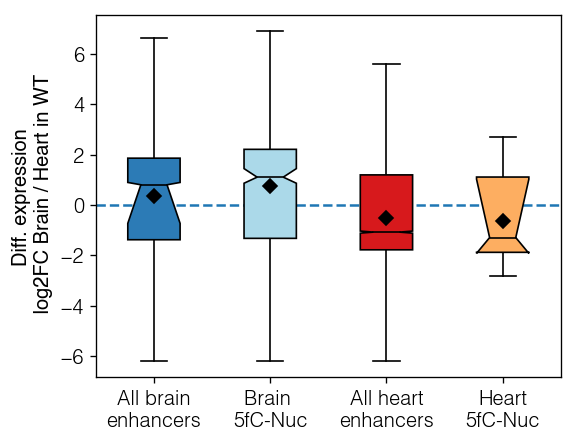

In [11]:
# Plot brain and heart
medianprops = dict(color='black')
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='black')
f, ax = plt.subplots(1, 1, sharex=True,
                    figsize=(5,4), dpi=120)
_ = ax.axhline(linestyle="--")
_ = ax.boxplot([list(de_enhancer_brain), 
                    list(logfc_b_5fCNuc_de), 
                    list(de_enhancer_heart),
                    list(logfc_h_5fCNuc_de)], 
                   showmeans=True, notch=True, 
                medianprops=medianprops,
               meanprops=meanpointprops,
                patch_artist=True,
                showfliers=False, 
                bootstrap=5000)
colors = ['#2c7bb6', '#abd9e9',"#d7191c", "#fdae61"]
for patch, color in zip(_['boxes'], colors):
    patch.set_facecolor(color)
names = ["All brain\nenhancers", "Brain \n5fC-Nuc", "All heart\nenhancers", "Heart\n5fC-Nuc"]
ax.set_ylabel("Diff. expression\n log2FC Brain / Heart in WT")
ax.set_xticklabels(names)
plt.savefig("boxplot_DE_tissues_WT_5fc.pdf", bbox_inches = 'tight')

Compute the p-values between pairs of tissue specific logFC, containing all the enhancers and only
the subset associated with tissue-unique 5fC-containing nucleosomes (for WT)

In [14]:
_, pval = stats.mannwhitneyu(list(de_enhancer_brain), list(logfc_b_5fCNuc_de))
print("pval WT DE genes related to all brain enhancers vs 5fC-Nuc associated enhancers", pval)
_, pval = stats.mannwhitneyu( list(de_enhancer_heart),
                    list(logfc_h_5fCNuc_de))
print("pval WT DE genes related to all heart enhancers vs 5fC-Nuc associated enhancers", pval)

pval WT DE genes related to all brain enhancers vs 5fC-Nuc associated enhancers 0.029345215307
pval WT DE genes related to all heart enhancers vs 5fC-Nuc associated enhancers 0.300619800064


---
## Now repeat the analysis for TDG KO

### Find 5fC-associated nucleosomes 

In [15]:
u5fC_brain_ko = pb.BedTool("5fC_unique_to_brain_KO.bed.gz")
u5fC_heart_ko = pb.BedTool("5fC_unique_to_heart_KO.bed.gz")
nuc_cons_brain_ko = pb.BedTool("ConsensusNucleosome_iNPS_Brain_KO_noMT.bed")
nuc_cons_heart_ko = pb.BedTool("ConsensusNucleosome_iNPS_Heart_KO_noMT.bed")

In [16]:
overlap=0.8
u5fC_brain_nuc = u5fC_brain_ko.intersect(nuc_cons_brain_ko, F=overlap, r=False)
u5fC_heart_nuc = u5fC_heart_ko.intersect(nuc_cons_heart_ko, F=overlap, r=False)

In [17]:
print("Number of 5fC-nuc_cons Brain:", len(u5fC_brain_nuc))
print("Number of 5fC-nuc_cons Heart:", len(u5fC_heart_nuc))

Number of 5fC-nuc_cons Brain: 21110
Number of 5fC-nuc_cons Heart: 27911


### Interesect with 5fC-Nucleosomes

In [19]:
# Enhancers from Ren Lab mm9 brain and heart
enhancer_brain = pb.BedTool("mm9_enhancer_brain_slop_1500.bed")
enhancer_heart = pb.BedTool("mm9_enhancer_heart_slop_1500.bed")
# BRAIN
num_b_5fCNuc_de = []
enhancers_unique_brain = enhancer_brain.intersect(u5fC_brain_nuc)
print("Brain TDG-KO DE 5fC-Nuc from Ren Lab enhancers --", len(set(find_genes_DE_inbed(enhancers_unique_brain, expr_ko))))
num_b_5fCNuc_de.append(len(set(find_genes_DE_inbed(enhancers_unique_brain, expr_ko))))
logfc_b_5fCNuc_de = set(find_DE_inbed(enhancers_unique_brain, expr_ko))

enhancers_not_unique_brain = enhancer_brain.intersect(u5fC_brain_nuc, v=True)
logfc_b_not_5fCNuc_de = set(find_DE_inbed(enhancers_not_unique_brain, expr_ko))

# HEART
num_h_5fCNuc_de = []
enhancers_unique_heart = enhancer_heart.intersect(u5fC_heart_nuc)
print("Heart TDG-KO DE 5fC-Nuc from Ren Lab enhancers --", len(set(find_genes_DE_inbed(enhancers_unique_heart, expr_ko))))
num_h_5fCNuc_de.append(len(set(find_genes_DE_inbed(enhancers_unique_heart, expr_ko))))
logfc_h_5fCNuc_de = set(find_DE_inbed(enhancers_unique_heart, expr_ko))

enhancers_not_unique_heart = enhancer_heart.intersect(u5fC_heart_nuc, v=True)
logfc_h_not_5fCNuc_de = set(find_DE_inbed(enhancers_not_unique_heart, expr_ko))

Brain TDG-KO DE 5fC-Nuc from Ren Lab enhancers -- 422
Heart TDG-KO DE 5fC-Nuc from Ren Lab enhancers -- 761


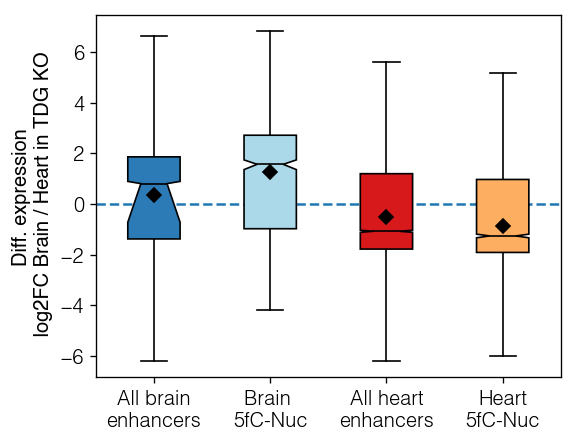

In [24]:
# Plot brain and heart
medianprops = dict(color='black')
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='black')
f, ax = plt.subplots(1, 1, sharex=True,
                    figsize=(5,4), dpi=120)
_ = ax.axhline(linestyle="--")
_ = ax.boxplot([list(de_enhancer_brain), 
                    list(logfc_b_5fCNuc_de), 
                    list(de_enhancer_heart),
                    list(logfc_h_5fCNuc_de)], 
                    meanprops=meanpointprops,
                   showmeans=True, notch=True, 
                showfliers=False, medianprops=medianprops, patch_artist=True, 
                bootstrap=5000)
colors = ['#2c7bb6', '#abd9e9',"#d7191c", "#fdae61"]
for patch, color in zip(_['boxes'], colors):
    patch.set_facecolor(color)
names = ["All brain\nenhancers", "Brain \n5fC-Nuc", "All heart\nenhancers", "Heart\n5fC-Nuc"]
ax.set_ylabel("Diff. expression\n log2FC Brain / Heart in TDG KO")
ax.set_xticklabels(names)

plt.savefig("boxplot_DE_tissues_KO_5fc.pdf", bbox_inches = 'tight')

Compute the p-values between pairs of tissue specific logFC, containing all the enhancers and only
the subset associated with tissue-unique 5fC-containing nucleosomes (for TDG-KO)

In [23]:
_, pval = stats.mannwhitneyu(list(de_enhancer_brain), list(logfc_b_5fCNuc_de), alternative='two-sided' )
print("pval TDG-KO DE genes related to all brain enhancers vs 5fC-Nuc associated enhancers", pval)
_, pval = stats.mannwhitneyu( list(de_enhancer_heart),
                    list(logfc_h_5fCNuc_de), alternative='two-sided')
print("pval TDG-KO DE genes related to all heart enhancers vs 5fC-Nuc associated enhancers", pval)

pval TDG-KO DE genes related to all brain enhancers vs 5fC-Nuc associated enhancers 9.77092203177e-14
pval TDG-KO DE genes related to all heart enhancers vs 5fC-Nuc associated enhancers 4.6552715776e-05


Thanks for watching. 